# Batch Denoising of scRNAseq Data

In this tutorial, we will guide you through the process of batch denoising scRNAseq datasets, which originate from different batches and laboratories.

To demonstrate the process, we will use the [human breast cell atals](https://www.nature.com/articles/s41588-024-01688-9), comprising over 800,000 human cells collected from 55 donors and sequenced across 45 batches. This dataset serves as a practical example for removing ambient noise during data integration. The original dataset can be accessed via [cellxgene](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637).

<div class="alert alert-info">

Note

To run this notebook on your device, ensure that you have scAR installed [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can run this notebook on Colab by clicking [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_batch_denoising_scRNAseq.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git

In [1]:
import pandas as pd
import seaborn as sns
import scanpy as sc
from scar import model

import warnings
warnings.simplefilter("ignore")

# Download data

The dataset can be downloaded from cellxgene by following command  
`wget -O HBCA.h5ad https://datasets.cellxgene.cziscience.com/5a611776-aae0-41b9-9f2b-aaf5f83771a3.h5ad
`  
The integrated dataset consists of 803,283 cells from 55 donors, sequenced across 45 batches. The batch information, labeled as 'processing_date' in Anndata.obs, is detailed in the Methods section of [Reed et al., Nature Genetics (2024)](https://www.nature.com/articles/s41588-024-01688-9)

In [2]:
!wget -O HBCA.h5ad https://datasets.cellxgene.cziscience.com/5a611776-aae0-41b9-9f2b-aaf5f83771a3.h5ad

--2024-08-12 23:48:21--  https://datasets.cellxgene.cziscience.com/5a611776-aae0-41b9-9f2b-aaf5f83771a3.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 108.156.172.87, 108.156.172.118, 108.156.172.19, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|108.156.172.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8493125588 (7.9G) [binary/octet-stream]
Saving to: ‘HBCA.h5ad’

100%[====================================>] 8,493,125,588  408MB/s   in 19s    

2024-08-12 23:48:41 (418 MB/s) - ‘HBCA.h5ad’ saved [8493125588/8493125588]



In [2]:
HBCA = sc.read_h5ad("HBCA.h5ad")
batches = HBCA.obs["processing_date"].unique()
print(f"There are {len(batches)} batches")

There are 45 batches


scAR allows for denoising a specific subset of genes and samples, making pre-filtering advisable to save computational time. In this case, we have subsetted the data to include only marker genes and highly variable genes, as provided in Figure 2 of [Reed et al., Nature Genetics (2024)](https://www.nature.com/articles/s41588-024-01688-9) and Anndata.var, respectively.

In [29]:
immune_markers = {
    'Immune': ['PTPRC', 'CXCR4'],
    'T cell lineage': ['CD3D', 'CD3G'],
    'B cells': ['MS4A1', 'CD79A'],
    'B_naive': ['YBX3', 'TCL1A'],
    'B_mem_switched': ['LTB', 'TNFRSF13C'],
    'B_mem_unswitched': ['MYC', 'EGR3'],
    'T cell': ['CD3D', 'CD3G'],
    'CD4 T (all)': ['CD4', 'CCR4'],
    'CD4_naive': ["SELL", "CD40LG"],
    'CD4_Th': ['CCL20', 'PTPN13'],
    'CD8 T (all)': ['CD8A', 'CD8B'],
    "CD8_Tem": ['GZMK', 'TNFRSF9'],
    'CD8_Trm': ['KLRC1', 'ITGA1'],
    'CD8_Tc1': ['IFNG', 'TNF'],
    'DC': ['CPVL', 'ID2'],
    'ILC': ['IL1R1', 'KIT'],
    'Macro': ['FCER1G', 'C1QB'],
    'Macro-lipo': ['APOE', 'GPNMB'],
    'NKT': ['GZMH', 'GZMB'],
    'NK': [ 'XCL2', 'KLRC3'],
    'Plasma_cell': ['IGKC', 'JCHAIN'],
}

stroma_markers = {
    'FB': ['DCN', 'LUM'],
    'FB1': ['COL1A2', 'VEGFD'],
    'FB2': ['ARSG', 'MMP3'],
    'FB3': ['GREM1', 'CLU'],
    'FB4': ['MTSS1', 'SLC2A1'],
    'PV': ['PDGFRB', 'NOTCH3', 'MYH11'],
    'PV1': ['ADRA2C', 'CTSC'],
    'PV2': ['GPAT2', 'PGAP1'],
    'PV3': ['RERGL', 'ACTA2'],
    'PV4': ['ADGRL3', 'GGT5'],
    'PV5': ['RGS5', 'THBS4'],
    'VE': ['PLVAP', 'PECAM1', 'CLDN5'],
    'VEV': ['ACKR1', 'SELP'],
    'VEC': ['CA4', 'CD36'],
    'VEA': ['SOX17', 'EFNB2'],
    'VEAT': ['PXDN', 'ANGPT2'],
    'LE': ['MMRN1', 'PDPN', 'CCL21'],
    'LE1': ['SEMA3D', 'B3GNT7'],
    'LE2': ['LYVE1', 'TXB1'],
}

Epi_markers = {
    'Epithelial': ['EPCAM', 'CDH1', 'KRT17'],
    'Lactocyte': ['CSN2', 'CSN3', 'LALBA'],
    'LASP': ['KIT', 'ALDH1A3', 'SLPI'],
    'LASP1': ['SERPINB3', 'MUC16'],
    'LASP2': ['KRT16', 'KRT6B'],
    'LASP3': ['RASSF1', 'COBL'],
    'LASP4': ['ROPN1', 'ELF5'],
    'LASP5': ['MKI67', 'TOP2A', 'BRCA1', 'BRCA2'],
    'LHS': ['AREG', 'ANKRD30A', 'FOXA1'],
    'LHS1': ['TMEM45B', 'CACNG4'],
    'LHS2': ['ESR1', 'PGR'],
    'LHS3': ['SERPINA1', 'PIP'],
    'BMYO': ['ACTG2', 'ACTA2', 'TAGLN'],
    'BMYO1': ['KRT14', 'KRT5'],
    'BMYO2': ['HSPA1B', 'OXTR'],
    'DDC1': ['MMP3', 'MUCL1'],
    'DDC2': ['KRT81', 'SAA1'],
}

genes = []
for k,v in immune_markers.items():
    genes+=v
for k,v in stroma_markers.items():
    genes+=v
for k,v in Epi_markers.items():
    genes+=v

In [4]:
HBCA.X = HBCA.raw.X
HBCA.var = HBCA.var.set_index("gene_name", drop=False)
HBCA.var.loc[HBCA.var_names.isin(genes), 'highly_variable'] = True
HBCA = HBCA[:, HBCA.var["highly_variable"]]

# Training

<div class="alert alert-info">

Note
    
The batch_key must be present in Anndata.obs.

The cache_capacity parameter determines the number of cells that can be stored in the GPU cache. A larger cache_capacity results in faster processing but requires more GPU memory.

During training, the initial ~15 epochs may be slow; however, once caching is complete, the speed increases significantly.

</div>

In [3]:
scar = model(
    raw_count=HBCA, # In the case of Anndata object, scar will automatically use the estimated ambient_profile present in HBCA.uns.
    batch_key='processing_date', # By default, it is set to None, meaning all cells are treated as being from a single batch.
    cache_capacity=900000, # Reduce the number if a GPU out-of-memory issue occurs.
    device='cuda', # cpu, cuda and mps are supported.
)

2024-08-13 15:54:27|INFO|model|cuda will be used.
2024-08-13 15:54:27|INFO|model|Found 45 batches defined by processing_date in AnnData.obs. Estimating ambient profile per batch...


In [ ]:
scar.train(
    epochs=300,
    batch_size=64,
    verbose=True
)

2024-08-13 15:54:33|INFO|VAE|Running VAE using the following param set:
2024-08-13 15:54:33|INFO|VAE|...denoised count type: mRNA
2024-08-13 15:54:33|INFO|VAE|...count model: binomial
2024-08-13 15:54:33|INFO|VAE|...num_input_feature: 5001
2024-08-13 15:54:33|INFO|VAE|...NN_layer1: 150
2024-08-13 15:54:33|INFO|VAE|...NN_layer2: 100
2024-08-13 15:54:33|INFO|VAE|...latent_space: 15
2024-08-13 15:54:33|INFO|VAE|...dropout_prob: 0.00
2024-08-13 15:54:33|INFO|VAE|...expected data sparsity: 0.90
2024-08-13 15:54:34|INFO|model|kld_weight: 1.00e-05
2024-08-13 15:54:34|INFO|model|learning rate: 1.00e-03
2024-08-13 15:54:34|INFO|model|lr_step_size: 5
2024-08-13 15:54:34|INFO|model|lr_gamma: 0.97


Training:  52%|█████▏    | 156/300 [4:50:57<2:40:54, 67.05s/it, Loss=9.6316e+02]

In [ ]:
# After training, we can infer the native true signal
scar.inference(batch_size=30000, get_native_frequencies=False)

In [ ]:
HBCA.raw = HBCA
HBCA.X = scar.native_counts
HBCA.write_h5ad(f"scAR_denoised_HBCA.h5ad", compression='gzip')

# Visualization

In [17]:
markers = {"Luminal adaptive secretory precurser": ['KIT', 'ALDH1A3', 'SLPI'],
           "Luminal hormone sensing": ['AREG', 'ANKRD30A', 'FOXA1'],
           "Basal-myoepithelial": ['ACTG2', 'ACTA2', 'TAGLN'],
           "DDC1": ["MMP3", "MUCL1"],
           "DDC2": ["KRT81", "SAA1"],
           "Fibroblast": ['DCN', 'LUM'],
           "Vascular endothelial": ['PLVAP', 'PECAM1', 'CLDN5'],
           "Lymphatic endothelial": ['MMRN1', 'PDPN', 'CCL21'],
           "Perivascular": ['PDGFRB', 'NOTCH3', 'MYH11'],
           "Lymphoid": ['PTPRC', 'CXCR4', 'CD3D', 'CD3G'],
           "Myeloid": ['FCER1G', 'C1QB', 'APOE', 'GPNMB'],
          }

In [13]:
HBCA.obs['level1'] = pd.Categorical(HBCA.obs['level1'], categories=markers.keys(), ordered=True)

Here, we present the expression of marker genes using the raw counts, which include ambient noise.

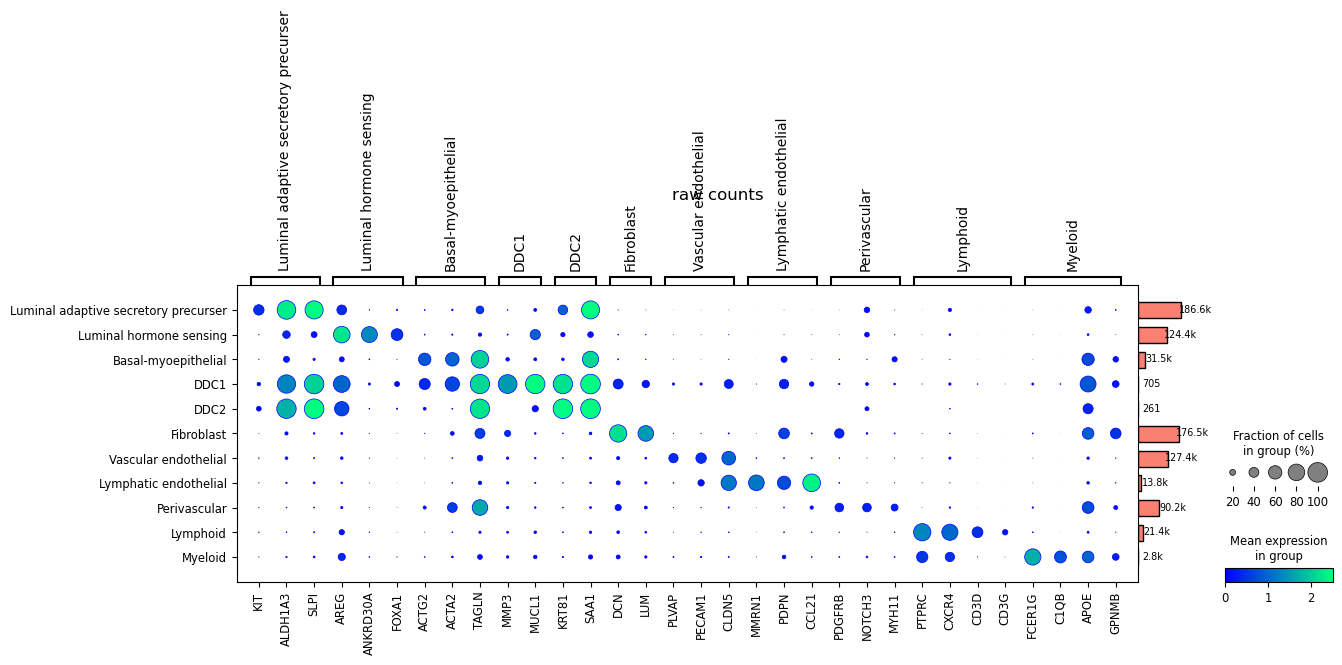

In [55]:
dp = sc.pl.dotplot(HBCA,
                   markers, 
                   groupby=['level1'],
                   dot_max=1.0,
                   dot_min=.0,
                   log=True, 
                   vmin=0, 
                   vmax=2.5,
                   title="raw counts",
                   return_fig=True
                  )
dp.add_totals().style(dot_edge_color='blue', dot_edge_lw=0.5).show()

After denoising, the dot plot reveals a much clearer expression profile.

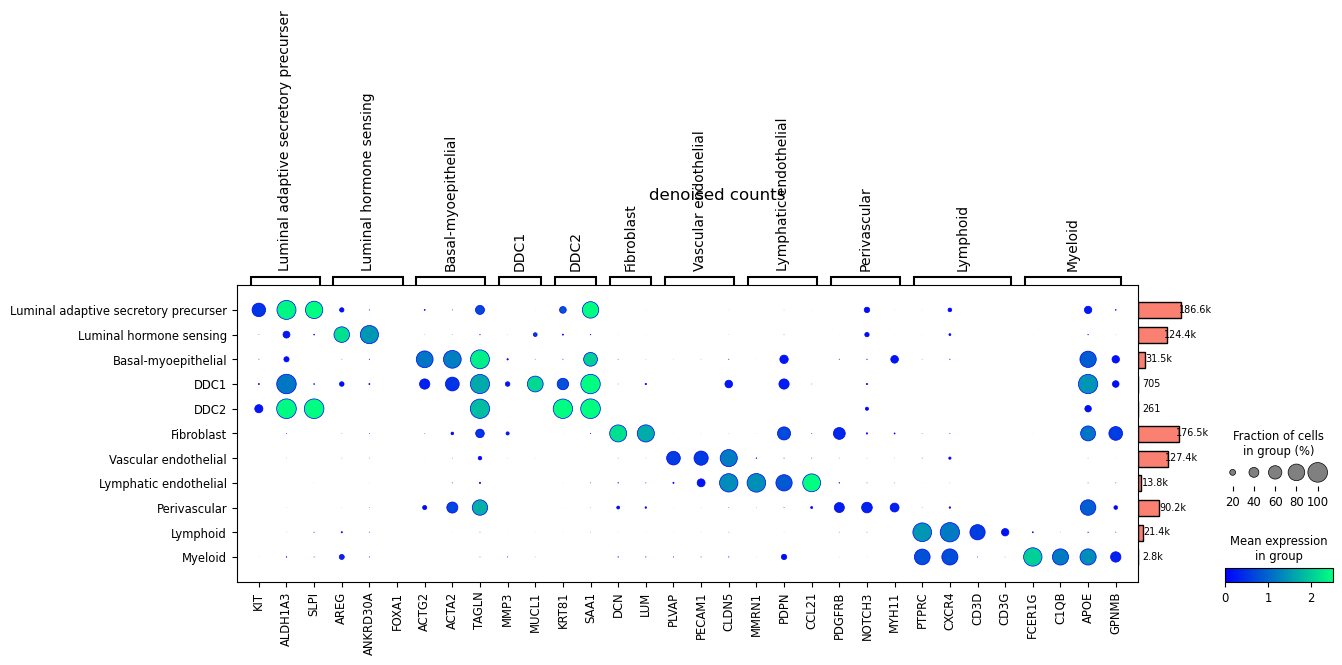

In [56]:
dp = sc.pl.dotplot(HBCA,
                   markers,
                   groupby=['level1'],
                   dot_max=1.0,
                   dot_min=.0,
                   log=True,
                   vmin=0,
                   vmax=2.5,
                   use_raw=False,
                   title="denoised counts",
                   return_fig=True
                  )
dp.add_totals().style(dot_edge_color='blue', dot_edge_lw=0.5).show()